In [50]:
import pandas as pd
from wordcloud import WordCloud
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import math
import stanza

%matplotlib inline
nlp = stanza.Pipeline('fr')

2021-12-11 12:47:09 INFO: Loading these models for language: fr (French):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |
| lemma     | gsd     |
| depparse  | gsd     |
| ner       | wikiner |

2021-12-11 12:47:09 INFO: Use device: cpu
2021-12-11 12:47:09 INFO: Loading: tokenize
2021-12-11 12:47:10 INFO: Loading: mwt
2021-12-11 12:47:10 INFO: Loading: pos
2021-12-11 12:47:10 INFO: Loading: lemma
2021-12-11 12:47:10 INFO: Loading: depparse
2021-12-11 12:47:12 INFO: Loading: ner
2021-12-11 12:47:14 INFO: Done loading processors!


In [41]:
def top_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids if row[i]>0]
    df = pd.DataFrame(top_feats)
    if len(top_feats) > 0:
        df.columns = ['feature', 'score']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_feats(row, features, top_n)

def cosinus(i, j):
    num = np.dot(i, j)
    den = math.sqrt(sum(i*i))*math.sqrt(sum(j*j))
    if (den>0):    
        return (num/den)
    else:
        return 0
    
def search(q, D, n_docs):
    cc = {i: cosinus(D[i, :], q) for i in range(n_docs)}
    cc = sorted(cc.items(), key=lambda x: x[1], reverse=True)
    return cc

def askforwords(queries):
    word = input("Quels mots cherchez-vous ? :  \n")
    if word != 'n' or word != '':
        queries = queries + [w for w in nltk.tokenize.word_tokenize(word)]

    answer = input("Souhaitez vous ajouter d'autres mots ? [y/n]  \n")
    if answer == 'n':
        return(queries)
    elif answer == 'y':
        askforwords(queries)
    else:
        print("ce paramètre n'est pas correct")
    
    return(queries)

In [45]:
import string

with open("./stopwords/Stop-words-french.txt", "r", encoding='utf8') as f:
    stopW1 = [line.rstrip("\n") for line in f.readlines()]
with open("./stopwords/stopword.txt", "r", encoding='utf8') as f:
    stopW2 = [line.rstrip("\n") for line in f.readlines()]
stopW = stopW1 + stopW2 #+ stopwords.words("french")
stopW.extend(string.punctuation)
stopW.extend(['’', '«', '»', '…', '—','».', '»,', '---', '.—', '…—', 'ans', 'an'])

In [154]:
df = pd.read_excel("./Exports/final_export.xlsx", )
#for i in range(len(df)):
#    df.preprocessed_xpo[i] = re.sub("'", "", str(df.preprocessed_xpo[i]))
df

,Unnamed: 0,id,titre,date,year,legislature,Exposé des motifs,Communiqué de presse,Productions,preprocessed_xpo
0,0,JORFDOLE000025417300,LOI n° 2012-346 du 12 mars 2012 relative aux m...,Tue Mar 13 01:00:00 2012,2012,XIIIème législature,NaN,NaN,4,NaN
1,1,JORFDOLE000031600244,LOI n° 2015-1705 du 21 décembre 2015 autorisan...,Thu Dec 24 01:00:00 2015,2015,XIVème législature,La France a signé le 18 décembre 2008 à Paris...,NaN,3,"['France', 'signer', 'Paris', 'accord', 'agenc..."
2,2,JORFDOLE000026453342,LOI n° 2012-1432 du 21 décembre 2012 relative ...,Mon Dec 24 01:00:00 2012,2012,XIVème législature,"NOR : INTX1232040L Depuis 1986, la France s'e...",NaN,6,"['INTXL', 'France', 'progressivement', 'doter'..."
3,3,JORFDOLE000043266698,LOI n° 2021-725 du 8 juin 2021 visant à sécuri...,Wed Jun 9 02:00:00 2021,2021,XVème législature,NaN,NaN,4,NaN
4,4,JORFDOLE000023856350,LOI n° 2011-939 du 10 août 2011 sur la partici...,Thu Aug 11 02:00:00 2011,2011,XIIIème législature,Le présent projet de loi poursuit deux object...,NaN,6,"['présent', 'poursuivre', 'objectif', 'amélior..."
...,...,...,...,...,...,...,...,...,...,...
740,740,JORFDOLE000030705573,LOI organique n° 2015-911 du 24 juillet 2015 r...,Sun Jul 26 02:00:00 2015,2015,XIVème législature,NaN,NaN,4,NaN
741,741,JORFDOLE000030641220,LOI n° 2015-957 du 3 août 2015 de règlement du...,Tue Aug 4 02:00:00 2015,2015,XIVème législature,NaN,Le ministre des finances et des comptes public...,0,"['ministre', 'finance', 'public', 'secrétaire'..."
742,742,JORFDOLE000018433118,LOI n° 2008-1091 du 28 octobre 2008 relative à...,Wed Oct 29 01:00:00 2008,2008,XIIIème législature,ExposÉ des motifs Le projet de loi qui vous e...,NaN,4,"['exposer', 'motif', 'présenter', 'viser', 'ré..."
743,743,JORFDOLE000023273651,LOI organique n° 2014-1392 du 24 novembre 2014...,Tue Nov 25 01:00:00 2014,2014,XIVème législature,Représentant de la Nation et garant du foncti...,NaN,4,"['représenter', 'nation', 'garant', 'fonctionn..."


In [166]:
Xpo = df.loc[df.preprocessed_xpo.isna() == False]
Xpo.reset_index(inplace=True, drop=True)
Xpo = Xpo.iloc[:,1:]
for i in range(len(Xpo)):
    Xpo.preprocessed_xpo[i] = re.sub("'", "", str(Xpo.preprocessed_xpo[i]))
#for i in range(len(Xpo)):
#    Xpo.preprocessed_xpo[i] = nltk.word_tokenize(Xpo.preprocessed_xpo[i])
Xpo

<ipython-input-166-3f69c9321f4d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xpo.preprocessed_xpo[i] = re.sub("'", "", str(Xpo.preprocessed_xpo[i]))


,id,titre,date,year,legislature,Exposé des motifs,Communiqué de presse,Productions,preprocessed_xpo
0,JORFDOLE000031600244,LOI n° 2015-1705 du 21 décembre 2015 autorisan...,Thu Dec 24 01:00:00 2015,2015,XIVème législature,La France a signé le 18 décembre 2008 à Paris...,NaN,3,"[France, signer, Paris, accord, agence, spatia..."
1,JORFDOLE000026453342,LOI n° 2012-1432 du 21 décembre 2012 relative ...,Mon Dec 24 01:00:00 2012,2012,XIVème législature,"NOR : INTX1232040L Depuis 1986, la France s'e...",NaN,6,"[INTXL, France, progressivement, doter, démocr..."
2,JORFDOLE000023856350,LOI n° 2011-939 du 10 août 2011 sur la partici...,Thu Aug 11 02:00:00 2011,2011,XIIIème législature,Le présent projet de loi poursuit deux object...,NaN,6,"[présent, poursuivre, objectif, améliorer, par..."
3,JORFDOLE000029254232,LOI n° 2014-1662 du 30 décembre 2014 portant d...,Wed Dec 31 01:00:00 2014,2014,XIVème législature,L'activité législative soutenue du Conseil de...,NaN,6,"[activité, législatif, soutenir, conseil, unio..."
4,JORFDOLE000017758144,LOI n° 2008-89 du 30 janvier 2008 relative à l...,Wed Jan 30 01:00:00 2008,2008,XIIIème législature,Le titre I er du projet de loi transpose la d...,NaN,2,"[er, transposer, directive, conseil, compléter..."
...,...,...,...,...,...,...,...,...,...
467,JORFDOLE000024603789,LOI n° 2011-1977 du 28 décembre 2011 de financ...,Thu Dec 29 01:00:00 2011,2011,XIIIème législature,NaN,"La ministre du budget, des comptes publics et ...",0,"[ministre, public, réforme, porte-parole, gouv..."
468,JORFDOLE000030641220,LOI n° 2015-957 du 3 août 2015 de règlement du...,Tue Aug 4 02:00:00 2015,2015,XIVème législature,NaN,Le ministre des finances et des comptes public...,0,"[ministre, finance, public, secrétaire, charge..."
469,JORFDOLE000018433118,LOI n° 2008-1091 du 28 octobre 2008 relative à...,Wed Oct 29 01:00:00 2008,2008,XIIIème législature,ExposÉ des motifs Le projet de loi qui vous e...,NaN,4,"[exposer, motif, présenter, viser, réformer, j..."
470,JORFDOLE000023273651,LOI organique n° 2014-1392 du 24 novembre 2014...,Tue Nov 25 01:00:00 2014,2014,XIVème législature,Représentant de la Nation et garant du foncti...,NaN,4,"[représenter, nation, garant, fonctionnement, ..."


In [150]:
Xpo.id.count()

745

<AxesSubplot:ylabel='feature'>

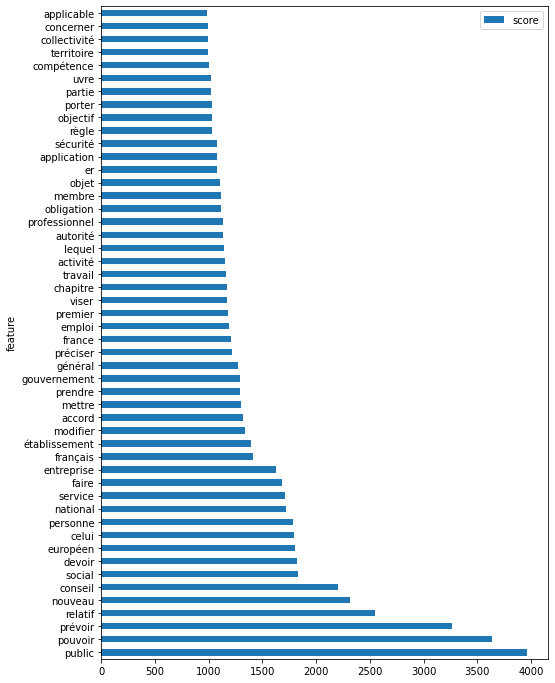

In [168]:
tf_vectorizer = CountVectorizer(stop_words = stopW)
titre = [item for item in Xpo.preprocessed_xpo]

#tit = nlp(titre)
#titre = [word.lemma for sent in titre.sentences for word in sent.words if word.upos != "VERB" and word.upos != "PRON"]

tf_vectorizer.fit(titre)
X = tf_vectorizer.transform(titre)
X = X.toarray()
features = tf_vectorizer.get_feature_names()

(num_doc, num_f) = X.shape

tf_sum = np.sum(X, axis=0)
tf = top_feats(tf_sum, features, 50)
top_feats(tf_sum, features, 50)

tf.index = tf.feature

tf.plot(kind="barh", figsize=(8,12))

In [201]:
words = ["prévoir", "relatif", "nouveau", "devoir", "celui", "faire", "modifier", "accord", "mettre", "prendre", "préciser", "viser", "lequel", "objet", " er", "porter", "uvre", "concerner", "fixer", "assurer", "renforcer", "définir"]
for i in range(len(titre)):
    for word in words:
        titre[i] = re.sub(word, "", titre[i])

<AxesSubplot:title={'center':'Mots les plus présents dans le corpus'}, ylabel='feature'>

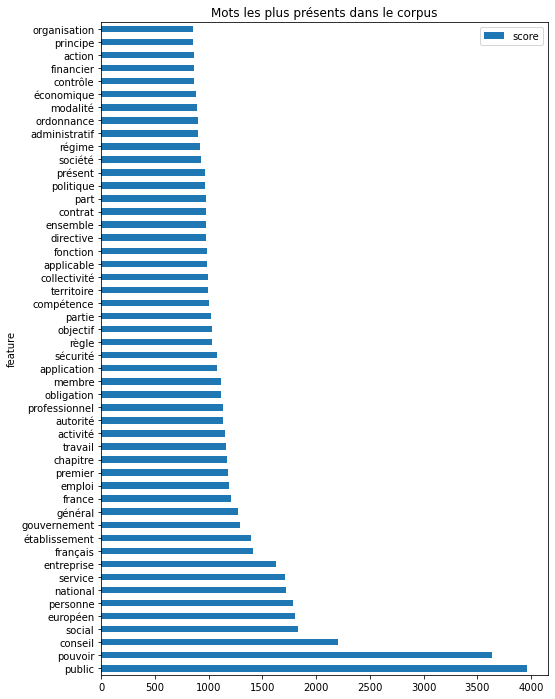

In [203]:
#tf_vectorizer = CountVectorizer(stop_words = stopW)
#titre = [item for item in Xpo.preprocessed_xpo]

#tit = nlp(titre)
#titre = [word.lemma for sent in titre.sentences for word in sent.words if word.upos != "VERB" and word.upos != "PRON"]

tf_vectorizer.fit(titre)
X = tf_vectorizer.transform(titre)
X = X.toarray()
features = tf_vectorizer.get_feature_names()

(num_doc, num_f) = X.shape

tf_sum = np.sum(X, axis=0)
tf = top_feats(tf_sum, features, 50)
top_feats(tf_sum, features, 50)

tf.index = tf.feature

tf.plot(kind="barh", figsize=(8,12), title="Mots les plus présents dans le corpus")

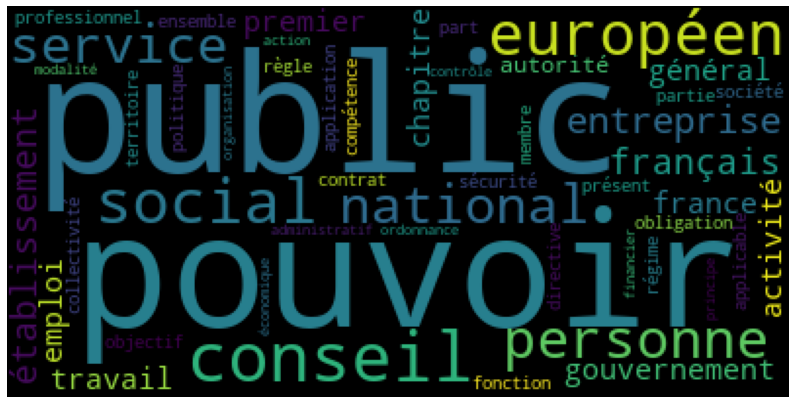

In [205]:
# les "labels" du nuage sont les mots
cloud_labels = features
# les poids correspondent à la somme des TF selon les lignes de la matrice
cloud_weights = tf_sum  #axis=0 ça veut dire qu'on prend les colonnes
# on construit un dictionnaire qui associe chaque label (mot) au poids correspondant (TF total)
dictionary = dict(zip(cloud_labels, cloud_weights)) # zip "colle" le vecteur des labels au vecteur des poids
# on trie par ordre décroissant
sorted_by_value = sorted(dictionary.items(), key=lambda kv: kv[1], reverse=True) #On dit qu'on trie à partir de la valeur située en 1 (donc le poids)

limit = 50
fontcolor='#fafafa'
bgcolor = '#000000'

wordcloud = WordCloud(
    max_words=limit,
    background_color=bgcolor,
).fit_words(dictionary)

fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [175]:
Xpo["secu"] = ["" for i in range(len(Xpo))]

for i in range(len(Xpo)):
    if "sécurité" in Xpo.preprocessed_xpo.loc[i]:
        Xpo["secu"].loc[i] = 1
    else:
        Xpo["secu"].loc[i] = 0


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:title={'center':'Apparition du mot "sécurité" dans le corpus de loi'}, xlabel='year'>

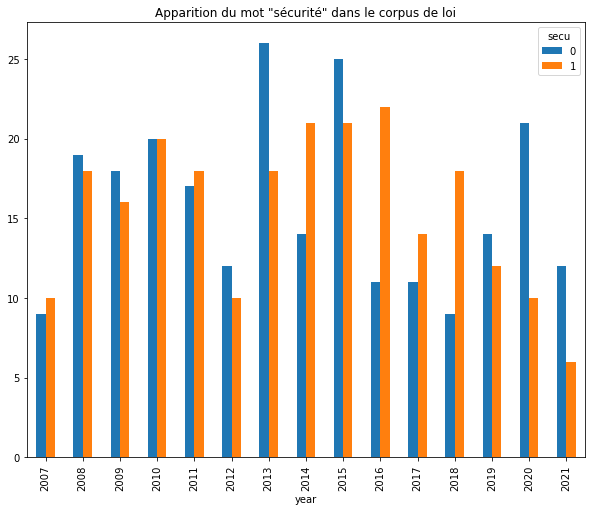

In [195]:
Xpo.groupby(['year', 'secu']).secu.count().unstack().plot(kind="bar", title="Apparition du mot \"sécurité\" dans le corpus de loi par année", figsize=(10,8))


<AxesSubplot:title={'center':'Apparition du mot "sécurité" dans le corpus de loi par législature'}, xlabel='legislature'>

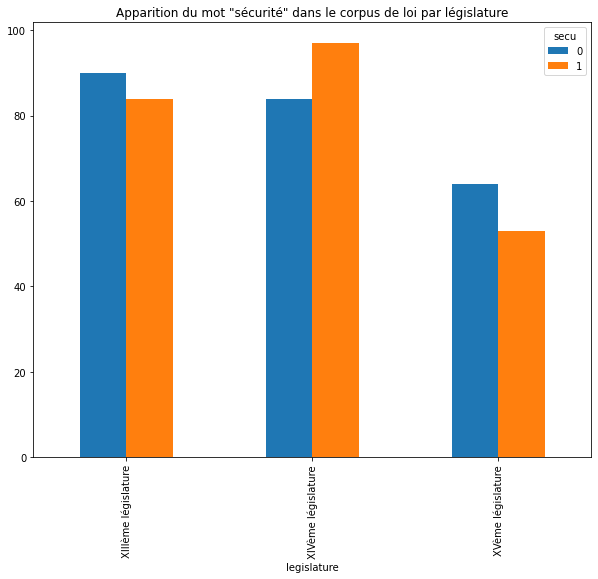

In [197]:
Xpo.groupby(['legislature', 'secu']).secu.count().unstack().plot(kind="bar", title="Apparition du mot \"sécurité\" dans le corpus de loi par législature", figsize=(10,8))

<AxesSubplot:title={'center':'Apparition du mot "sécurité" dans le corpus de loi, en fonction du nombre de productions dans les débats parlementaires'}, xlabel='Productions'>

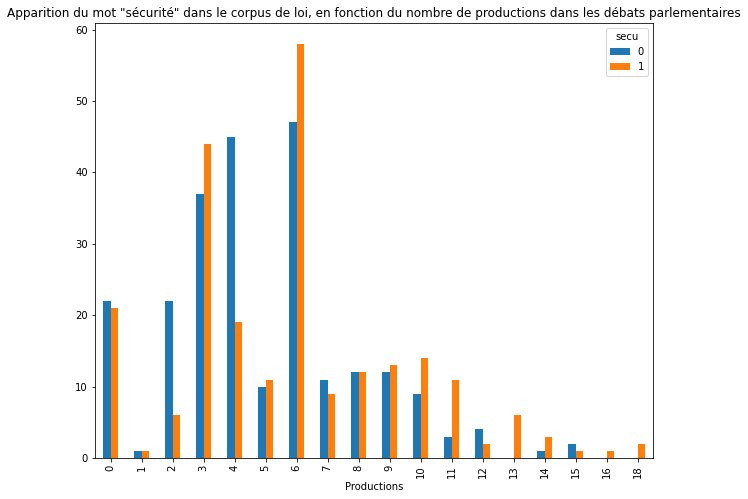

In [200]:
Xpo.groupby(['Productions', 'secu']).secu.count().unstack().plot(kind="bar", title="Apparition du mot \"sécurité\" dans le corpus de loi, en fonction du nombre de productions dans les débats parlementaires", figsize=(10,8))

## Pour la fin 

In [35]:
Xpo["secu"] = ["" for i in range(len(Xpo))]

for i in range(len(Xpo.preprocessed_xpo)):
    for word in Xpo.preprocessed_xpo.iloc[i]:
        if "sécurité" in word:
            Xpo["secu"].iloc[i] = 1
        else:
            Xpo["secu"].iloc[i] = 0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


KeyboardInterrupt: 

In [ ]:
Xpo.secu

In [ ]:
xpo = [xpo for xpo in Xpo.preprocessed_xpo]